In [31]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [32]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


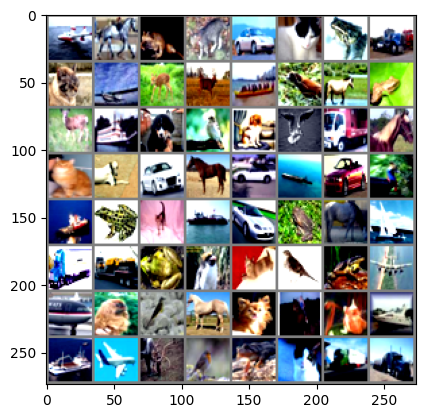

airplane horse frog cat automobile cat frog truck cat airplane deer deer ship bird horse frog deer ship dog bird dog bird truck horse cat dog automobile horse automobile ship automobile bird ship frog cat ship automobile frog horse ship truck truck frog bird cat bird frog airplane airplane dog bird horse dog horse cat ship ship airplane deer bird frog cat truck truck


In [33]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [34]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2


        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
   
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

    
        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  

        qkv = self.qkv_proj(x)  # (B, N, 3 * D)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) 
        q, k, v = qkv[0], qkv[1], qkv[2]  

        # Scaled dot-product attention

        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        context = torch.matmul(attn_probs, v)
        
        context = context.transpose(1, 2).reshape(B, N, D)

        out = self.out_proj(context)
        return out


class ViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()
        # Layer Norm 1 (for attention)
        self.norm1 = nn.LayerNorm(input_dim)
        # Multi-head self-attention
        self.attn = MultiHeadSelfAttention(input_dim, num_heads, dropout)
        # Layer Norm 2 (for MLP)
        self.norm2 = nn.LayerNorm(input_dim)
        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):

        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))
        return x


class ViTClassifier(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, dropout=0.0
    ):
        super().__init__()
   
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }
        
      
        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
        
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        self.dropout = nn.Dropout(dropout)
        
       
        self.transformer = nn.Sequential(
            *[ViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
       
        self.norm = nn.LayerNorm(embed_dim)
        

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
     
        B = x.shape[0]
        
      
        x = self.patch_embedding(x)  
        
        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  
        x = torch.cat((cls_tokens, x), dim=1) 
        
        # Add positional embeddings
        x = x + self.pos_embed  
        x = self.dropout(x)
        
        # Apply transformer blocks
        x = self.transformer(x)
        
        # Apply layer norm
        x = self.norm(x)
        
        # Use the class token for classification
        x = x[:, 0] 
        
        # Classification head
        x = self.head(x)  # (B, num_classes)
        
        return x

In [47]:
image_size = 32  
patch_size = 4   
num_channels = 3 
embed_dim = 192   
hidden_dim = 768 
num_heads = 8 
num_layers = 6
num_classes = 10  
dropout = 0.1
    
model = ViTClassifier(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=num_channels,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout
)
model = model.to(device)
    

Epoch [1/30], Step [100/782], Loss: 2.0036, Acc: 26.06%
Epoch [1/30], Step [200/782], Loss: 1.8452, Acc: 28.43%
Epoch [1/30], Step [300/782], Loss: 1.7502, Acc: 30.55%
Epoch [1/30], Step [400/782], Loss: 1.7172, Acc: 32.05%
Epoch [1/30], Step [500/782], Loss: 1.6565, Acc: 33.42%
Epoch [1/30], Step [600/782], Loss: 1.5908, Acc: 34.84%
Epoch [1/30], Step [700/782], Loss: 1.5505, Acc: 36.08%
Epoch [1/30] - Test Loss: 1.4864, Test Acc: 45.69%
Epoch [2/30], Step [100/782], Loss: 1.4809, Acc: 46.55%
Epoch [2/30], Step [200/782], Loss: 1.4425, Acc: 47.08%
Epoch [2/30], Step [300/782], Loss: 1.4070, Acc: 47.43%
Epoch [2/30], Step [400/782], Loss: 1.3902, Acc: 48.06%
Epoch [2/30], Step [500/782], Loss: 1.4081, Acc: 48.18%
Epoch [2/30], Step [600/782], Loss: 1.3371, Acc: 48.73%
Epoch [2/30], Step [700/782], Loss: 1.3154, Acc: 49.35%
Epoch [2/30] - Test Loss: 1.2871, Test Acc: 53.17%
Epoch [3/30], Step [100/782], Loss: 1.2687, Acc: 54.39%
Epoch [3/30], Step [200/782], Loss: 1.2469, Acc: 54.98%
Ep

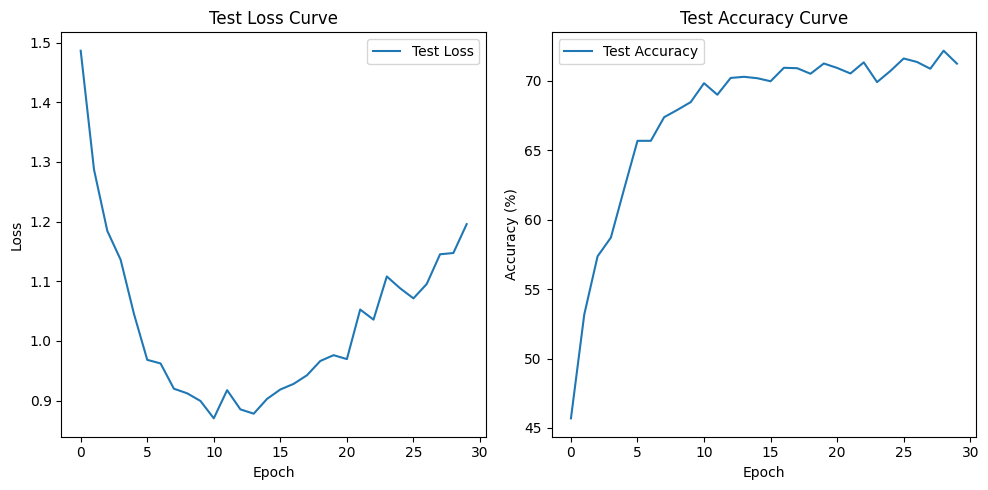

In [48]:
num_epochs=30 
batch_size=64
learning_rate=1e-4  
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
 

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
    

for epoch in range(num_epochs):
        # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
        optimizer.zero_grad()
            
            # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
            # Backward pass and optimize
        loss.backward()
        optimizer.step()
            
            # Compute statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
            
            # Print progress
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                   f'Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
        
        # Calculate epoch training statistics
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
        
        # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
    test_acc = 100. * correct / total
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
        
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
         f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

Epoch [1/30], Step [100/782], Loss: 2.0276, Acc: 24.61%
Epoch [1/30], Step [200/782], Loss: 1.9119, Acc: 26.80%
Epoch [1/30], Step [300/782], Loss: 1.7942, Acc: 28.89%
Epoch [1/30], Step [400/782], Loss: 1.7192, Acc: 30.79%
Epoch [1/30], Step [500/782], Loss: 1.6796, Acc: 32.20%
Epoch [1/30], Step [600/782], Loss: 1.6369, Acc: 33.43%
Epoch [1/30], Step [700/782], Loss: 1.6223, Acc: 34.40%
Epoch [1/30] - Test Loss: 1.5268, Test Acc: 43.72%
Epoch [2/30], Step [100/782], Loss: 1.5277, Acc: 43.59%
Epoch [2/30], Step [200/782], Loss: 1.4968, Acc: 44.43%
Epoch [2/30], Step [300/782], Loss: 1.4745, Acc: 45.05%
Epoch [2/30], Step [400/782], Loss: 1.4390, Acc: 45.85%
Epoch [2/30], Step [500/782], Loss: 1.4104, Acc: 46.47%
Epoch [2/30], Step [600/782], Loss: 1.3965, Acc: 46.87%
Epoch [2/30], Step [700/782], Loss: 1.3781, Acc: 47.28%
Epoch [2/30] - Test Loss: 1.3911, Test Acc: 49.75%
Epoch [3/30], Step [100/782], Loss: 1.3014, Acc: 52.45%
Epoch [3/30], Step [200/782], Loss: 1.2914, Acc: 52.62%
Ep

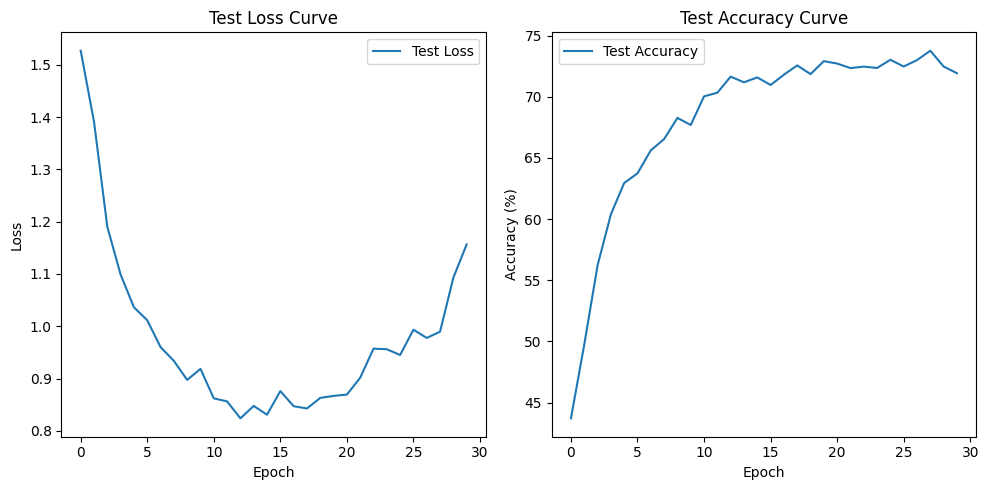

In [50]:
image_size = 32  
patch_size = 2  
num_channels = 3 
embed_dim = 192   
hidden_dim = 768 
num_heads = 8 
num_layers = 6
num_classes = 10  
dropout = 0.1
    
model = ViTClassifier(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=num_channels,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout
)
model = model.to(device)

num_epochs=30 
batch_size=64
learning_rate=1e-4  
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
 

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
    

for epoch in range(num_epochs):
        # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
        optimizer.zero_grad()
            
            # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
            # Backward pass and optimize
        loss.backward()
        optimizer.step()
            
            # Compute statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
            
            # Print progress
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                   f'Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
        
        # Calculate epoch training statistics
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
        
        # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
    test_acc = 100. * correct / total
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
        
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
         f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
    

Epoch [1/30], Step [100/782], Loss: 1.9934, Acc: 27.19%
Epoch [1/30], Step [200/782], Loss: 1.8697, Acc: 29.13%
Epoch [1/30], Step [300/782], Loss: 1.7715, Acc: 30.84%
Epoch [1/30], Step [400/782], Loss: 1.7360, Acc: 32.32%
Epoch [1/30], Step [500/782], Loss: 1.6897, Acc: 33.67%
Epoch [1/30], Step [600/782], Loss: 1.6436, Acc: 34.88%
Epoch [1/30], Step [700/782], Loss: 1.6522, Acc: 35.57%
Epoch [1/30] - Test Loss: 1.5675, Test Acc: 43.27%
Epoch [2/30], Step [100/782], Loss: 1.5777, Acc: 42.22%
Epoch [2/30], Step [200/782], Loss: 1.5689, Acc: 42.40%
Epoch [2/30], Step [300/782], Loss: 1.5403, Acc: 43.15%
Epoch [2/30], Step [400/782], Loss: 1.5085, Acc: 43.65%
Epoch [2/30], Step [500/782], Loss: 1.4978, Acc: 44.09%
Epoch [2/30], Step [600/782], Loss: 1.4544, Acc: 44.54%
Epoch [2/30], Step [700/782], Loss: 1.4678, Acc: 44.80%
Epoch [2/30] - Test Loss: 1.4304, Test Acc: 48.07%
Epoch [3/30], Step [100/782], Loss: 1.3838, Acc: 49.66%
Epoch [3/30], Step [200/782], Loss: 1.3851, Acc: 49.81%
Ep

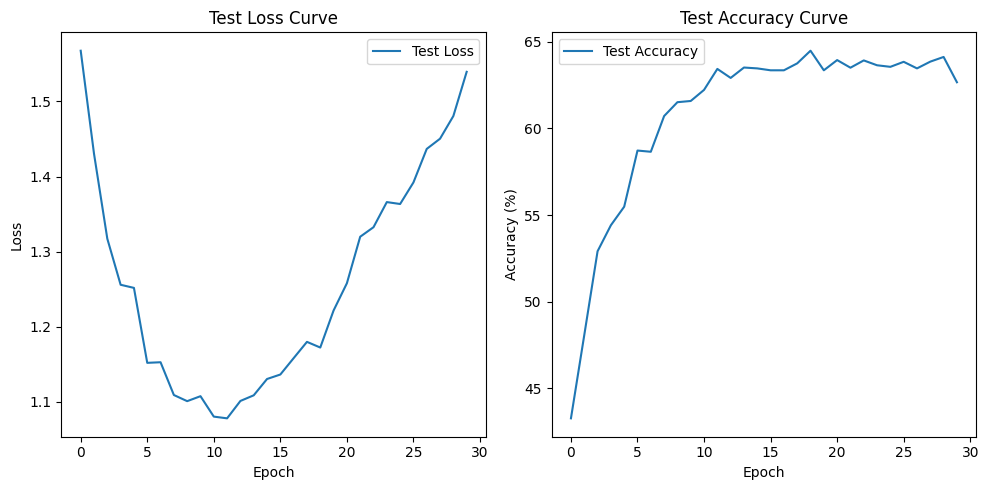

In [51]:
image_size = 32  
patch_size = 8 
num_channels = 3 
embed_dim = 192   
hidden_dim = 768 
num_heads = 8 
num_layers = 6
num_classes = 10  
dropout = 0.1
    
model = ViTClassifier(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=num_channels,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout
)
model = model.to(device)

num_epochs=30 
batch_size=64
learning_rate=1e-4  
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
 

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
    

for epoch in range(num_epochs):
        # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
        optimizer.zero_grad()
            
            # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
            # Backward pass and optimize
        loss.backward()
        optimizer.step()
            
            # Compute statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
            
            # Print progress
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                   f'Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
        
        # Calculate epoch training statistics
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
        
        # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
    test_acc = 100. * correct / total
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
        
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
         f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()
    